<a href="https://colab.research.google.com/github/KotkaZ/journey-to-zero/blob/master/DeepNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Network Notebook
This notebook contains data processing and Neural Network model. The input data is a JourneyToZero Kaggle competition.

https://www.kaggle.com/competitions/predict-electricity-consumption


In [1]:
# Here we use Numpy arrays and Pandas dataframes to pass and modify data.
import numpy as nb
import pandas as pd

# We use OneHotEncoder from preprocessing sklearn module.
from sklearn import preprocessing

# We use PCA from decomposition sklearn module.
from sklearn import decomposition

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout


from matplotlib import pyplot as plt
%matplotlib inline

import datetime

### Timestamp extraction

Because crazy things happened in the past year, we validated that, some specific dates had significantly higher electricity prices. Therefore we do weekday, month, and time extraction from the timestamp.

We only extract timestap features.



In [2]:
def extract_weekday(dataset):
    splits = dataset['date'].astype(str).str.split('-')
    dataset['weekday'] = [datetime.date(int(year), int(month), int(day)).weekday() for (year, month, day) in splits]

In [3]:
def extract_month(dataset):
    dataset['month'] = [month for (_, month, _) in dataset['date'].astype(str).str.split('-')]

In [4]:
def extract_datetime(dataset):
    dataset.loc[:,'time'] = pd.to_datetime(dataset.loc[:,'time'], format="%Y-%m-%d %H:%M:%S", utc=True)
    dataset['date'] = dataset['time'].dt.date
    dataset['hour'] = dataset['time'].dt.hour

In [5]:
def extract_features(dataset):
    extract_datetime(dataset)
    extract_month(dataset)
    extract_weekday(dataset)


### One Hot Encoder

As Neural Networks prefer numerical inputs we encode categorical data.

In [6]:
def one_hot_encode(dataset, columns, encoder = None) -> preprocessing.OneHotEncoder:
    if encoder:
        transformed = encoder.transform(dataset[columns])
    else:
        encoder = preprocessing.OneHotEncoder(sparse= False)
        transformed = encoder.fit_transform(dataset[columns])

    new_columns = []
    for i, column in enumerate(encoder.feature_names_in_):
        new_columns.extend([column + str(cat) for cat in encoder.categories_[i]])

    encoder_df = pd.DataFrame(transformed, index=dataset.index)
    dataset[new_columns] = encoder_df
    dataset.drop(columns=columns, inplace=True)
    return encoder

### Feature dropping

In Estonia, there are approximately 500-800 millimeters of rain on average. Our dataset consisted of only about 140mm of rain, which is definitely not correct. Also, the amount of snow was inappropriate for the same reason. We could integrate a new wether dataset or leave it as it is. The simpliest approch is to delete the whole columns, which we decided to do.

Some of the rows contained null values, which we also dropped. There was a case, when electricy prices hit market limit, which caused some outliners. It was wise to drop them.


In [7]:
def drop_features(dataset):
    dataset.drop(columns=['snow','prcp','time','date'], inplace=True)


In [8]:
def drop_rows(dataset):
    # Deal with NaN values
    initial_len = len(dataset)
    dataset.dropna(inplace=True)
    new_len = len(dataset)
    if (initial_len != new_len):
        print(f'Dropped {initial_len - new_len} row')

    # Deal with outliners
    dataset.drop(dataset[dataset['el_price'] > 1].index , inplace=True)

### Normalize

Here we scale numeric values between 0 to 1 with MinMaxScaler

In [9]:
def normalize(dataset, scaler = None) -> (pd.DataFrame, preprocessing.MinMaxScaler):
    if scaler:
        dataset_scaled = scaler.transform(dataset)
        return (dataset_scaled, scaler)
    scaler = preprocessing.MinMaxScaler()
    dataset_scaled = scaler.fit_transform(dataset)
    return (dataset_scaled, scaler)

### PCA

As OneHotEncoder introduced a lot of new features, we decided to do PCA with leaving 90% of importance value.

In [10]:
def reduce_dimensions(dataset, pca = None) -> (pd.DataFrame, decomposition.PCA):
    if pca:
        dataset_reduced = pca.transform(dataset)
        return (dataset_reduced, pca)
    pca = decomposition.PCA(n_components=0.9)
    dataset_reduced = pca.fit_transform(dataset)
    return (dataset_reduced, pca)

### Preprocess

Here we combine all the previous methods into one. As trained encoder must be used on test set, we return it from the method.


In [11]:
def preprocess(dataset, encoder=None) -> preprocessing.OneHotEncoder:
    extract_features(dataset)
    drop_features(dataset)
    encoder = one_hot_encode(dataset, ['coco', 'weekday'], encoder)
    drop_rows(dataset)
    return encoder


### Import dataset

Here we import dataset, do inital processing and split into train and validation. As we predict consumption, we extract this column to separate numpy array.

In [12]:
def read_dataset(file_name) -> pd.DataFrame:
    return pd.read_csv(file_name)

In [13]:
def extract_labels(dataset) -> (pd.DataFrame, pd.Series):
    X_train = dataset.loc[:, ~dataset.columns.isin(['consumption'])]
    y_train = dataset['consumption']
    return (X_train, y_train)

In [14]:
train_df = read_dataset('train.csv')
encoder = preprocess(train_df)


X_train, y_train = extract_labels(train_df)

X_train_norm, scaler = normalize(X_train)
X_train_reduced, pca = reduce_dimensions(X_train_norm)


Dropped 2 row


In [15]:
X_train_norm.shape

(8588, 41)

In [16]:
X_test = read_dataset('test.csv')
preprocess(X_test, encoder)

X_test_norm, _ = normalize(X_test, scaler)
print(X_test_norm.shape)
X_test_reduced, _ = reduce_dimensions(X_test_norm, pca)

(168, 41)


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_reduced, y_train, test_size=0.2)

In [18]:
X_train.shape

(6870, 16)

### Deep Neural Network

We train a quite random Nerual Network too see the possible potential of this model. We validate the output on validation set.



In [19]:
mdl = Sequential()

mdl.add(Dense(2056, activation="relu", input_shape=(X_train.shape[1],)))
mdl.add(BatchNormalization())
mdl.add(Dropout(0.2))
mdl.add(Dense(1028, activation="relu"))
mdl.add(Dropout(0.2))
mdl.add(BatchNormalization())
mdl.add(Dense(512, activation="relu"))
mdl.add(Dropout(0.2))
mdl.add(BatchNormalization())
mdl.add(Dense(64, activation="relu"))
mdl.add(BatchNormalization())
mdl.add(Dense(32, activation="relu"))
mdl.add(Dropout(0.2))
mdl.add(Dense(1, activation="relu"))

mdl.compile(loss='mae', optimizer="adam")

In [20]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test_reduced.shape)

(6870, 16)
(6870,)
(1718, 16)
(1718,)
(168, 16)


In [21]:
history = mdl.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=20, batch_size=32, verbose=True)

Epoch 1/20
215/215 [==============================] - 11s 41ms/step - loss: 0.8244 - val_loss: 0.6368
Epoch 2/20
215/215 [==============================] - 7s 33ms/step - loss: 0.6791 - val_loss: 0.6425
Epoch 3/20
215/215 [==============================] - 5s 22ms/step - loss: 0.6340 - val_loss: 0.5979
Epoch 4/20
215/215 [==============================] - 5s 22ms/step - loss: 0.6038 - val_loss: 0.5895
Epoch 5/20
215/215 [==============================] - 5s 22ms/step - loss: 0.5858 - val_loss: 0.5650
Epoch 6/20
215/215 [==============================] - 5s 21ms/step - loss: 0.5725 - val_loss: 0.5808
Epoch 7/20
215/215 [==============================] - 5s 22ms/step - loss: 0.5670 - val_loss: 0.5498
Epoch 8/20
215/215 [==============================] - 5s 21ms/step - loss: 0.5396 - val_loss: 0.5423
Epoch 9/20
215/215 [==============================] - 5s 22ms/step - loss: 0.5375 - val_loss: 0.5388
Epoch 10/20
215/215 [==============================] - 5s 21ms/step - loss: 0.5288 - val_l

Text(0.5, 1.0, 'Loss')

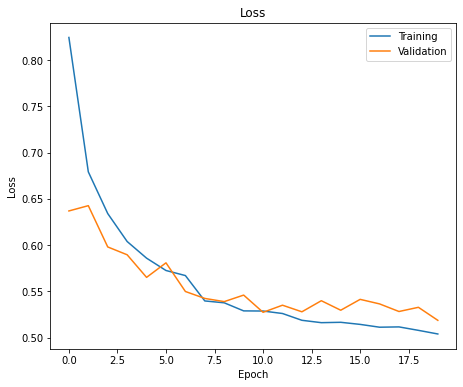

In [22]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')


### Prediction
We predict on the test dataset and write the output to csv file.



In [23]:
prediction = mdl.predict(X_test_reduced)
prediction

6/6 [==============================] - 0s 6ms/step


array([[0.33029175],
       [0.29407609],
       [0.18818377],
       [0.14235905],
       [0.16753966],
       [0.2193278 ],
       [0.29369366],
       [0.3816925 ],
       [0.4060542 ],
       [0.5076452 ],
       [0.53012526],
       [0.4640003 ],
       [0.4736016 ],
       [0.47693273],
       [0.49287188],
       [0.5061378 ],
       [0.5751084 ],
       [0.59844714],
       [0.7681807 ],
       [0.6937176 ],
       [0.62664974],
       [0.59832513],
       [0.31309396],
       [0.29152292],
       [0.2880332 ],
       [0.23371422],
       [0.22092439],
       [0.15449843],
       [0.18515241],
       [0.2180231 ],
       [0.28819323],
       [0.3912422 ],
       [0.4808802 ],
       [0.5174941 ],
       [0.42951664],
       [0.46734196],
       [0.4845786 ],
       [0.59894836],
       [0.50607306],
       [0.63695467],
       [0.56380713],
       [0.5891514 ],
       [0.5924567 ],
       [0.57882094],
       [0.44456992],
       [0.41200387],
       [0.31537566],
       [0.274

In [24]:
# We must reload the test dataframe, as we droped the time column.
X_test = read_dataset('test.csv')

predictions_dict = {'time':X_test.time,'consumption':[el[0]for el in prediction]}
pred_df = pd.DataFrame(predictions_dict)
pred_df.to_csv('submission_291022_v1.csv',index=False)